# Contoso Sales Analysis Assistant

## Why use the OpenAI Assistants API

The OpenAI Assistants API allows you to build conversational agents that can understand and respond to user inputs. You can use the API to automate tasks, provide information, or guide users through a process.

The Assistants API is not the only way to build conversational agents, but it offers several advantages:

1. Simplicity: The API abstracts away the complexity of building a conversational agent, allowing you to focus on the content and logic of the conversation.
2. Scalability: The API is designed to handle a large number of concurrent users, making it suitable for production use.
3. Customization: The API allows you to customize the behavior of the assistant by providing training data and defining conversational flows.
4. Integration: The API can be integrated with other services and systems, allowing you to build assistants that interact with external data sources.

## Core concepts

The OpenAI Assistants API is based on a few core concepts that you need to understand in order to build conversational agents:

### Conversational agents

A conversational agent is a computer program that can interact with users in a natural language. The agent can understand user inputs, generate responses, and maintain a context of the conversation.

### Conversational flows

A conversational flow is a sequence of interactions between the user and the assistant. The flow can include questions, prompts, and responses that guide the user through a process or provide information.

### The Assistant object

The Assistant object is the main interface for interacting with the Assistants API. You can create an Assistant object by providing your API key and the ID of the assistant you want to use.

### The Thread object

The Thread object represents a conversation thread between the user and the assistant.

### Function calling

The Assistants API allows you to define custom functions that can be called from within the conversation. These functions can perform tasks, retrieve data, or interact with external services.

### Code Generation

The Assistants API can generate Python code to be executed in a sandboxed environment. This code can be used to define custom functions, manipulate data, or perform calculations. The generated code is executed in a secure environment to prevent malicious behavior.

## Objective

This notebook demonstrates the following:

1. Generative AI
1. Function calling
1. Code Generation

Reference:
- Learn more about how to use Assistants with our [How-to guide on Assistants](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/assistant)
- [Assistants OpenAI Overview](https://platform.openai.com/docs/assistants/overview) 

<!-- - Function Calling with Yfinance to get latest stock prices. Summarization of user provided article. Extract country info from article, extract country, capital and other aspects, and call an API to get more information about each country.

This tutorial uses the following Azure AI services:
- Access to Azure OpenAI Service - you can apply for access [here](https://aka.ms/oai/access)
- Azure OpenAI service - you can create it from instructions [here](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource)
- Azure OpenAI Studio - go to [https://oai.azure.com/](https://oai.azure.com/) to work with the Assistants API Playground
- A connection to the Azure OpenAI Service with a [Key and Endpoint](https://learn.microsoft.com/en-us/azure/ai-services/openai/chatgpt-quickstart)

-->

## Time

You should expect to spend 10-15 minutes running this sample. 

## About this example

The objective of the provided Python file is to create an Azure OpenAI Assistant named "Contoso Sales Analysis Assistant" using the Azure OpenAI API. The assistant is designed to act as a sales analysis assistant, providing information and insights related to the contoso business sales. The script initiates a conversation with the assistant, guiding it through various financial queries and scenarios to showcase its capabilities.

### Data
This sample uses files from the folder [`data/`](./data/) in this repo. You can clone this repo or copy this folder to make sure you have access to these files when running the sample.



## Installation

Refer to the README.md file in this folder for installation instructions.

In [1]:
# Install the packages
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Parameters

In [2]:
import os
from dotenv import load_dotenv

load_dotenv(".env")
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")

DATA_FOLDER = "data/"

assistant = None
thread = None
should_cleanup: bool = False

In [3]:
import io
import json
from datetime import datetime
from pathlib import Path
from typing import Iterable
from PIL import Image
from IPython.display import display
import sqlite3
import pandas as pd

import yfinance as yf
from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta.threads import Message, TextContentBlock, ImageFileContentBlock, Run
from openai.types.beta.thread import Thread

In [4]:
con = sqlite3.connect('./database/order_data.db')

In [5]:
def get_revenue_by_region() -> pd.DataFrame:
    query = """
        SELECT 
            Region,
            SUM(Number_of_Orders) as Number_of_Orders, 
            CAST(SUM(Sum_of_Order_Value_USD) AS INTEGER) as Total_Order_Value,
            SUM(Sum_of_Order_Value_USD)/SUM(Number_of_Orders) as Avg_Order_Value,
            SUM(Sum_of_Shipping_Cost_USD)/SUM(Number_of_Orders) as Avg_Shipping_Cost
        FROM order_data GROUP BY Region ORDER BY Total_Order_Value
    """
    return pd.read_sql_query(query, con)

In [6]:
def get_sales_by_month(month: int) -> pd.DataFrame:
    query = """
        SELECT   
            SUM(Sum_of_Order_Value_USD) AS Revenue, Month, Year
            FROM order_data WHERE Month = ? GROUP BY Month, Year ORDER BY Year, Month
    """

    return pd.read_sql_query(query, con, params=[month])

In [7]:
get_revenue_by_region()

,Region,Number_of_Orders,Total_Order_Value,Avg_Order_Value,Avg_Shipping_Cost
0,NORTH AMERICA,62555,1092029,17.457103,7.502805
1,EUROPE,61719,1199818,19.440016,7.502063
2,ASIA-PACIFIC,61337,1344150,21.914194,7.490754
3,AFRICA,61209,1533671,25.056306,7.507702
4,MIDDLE EAST,61168,1786876,29.212609,7.502444
5,SOUTH AMERICA,61193,2147262,35.090006,7.475050


### Create an AzureOpenAI client

In [8]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

### Define the Assistant tools

In [9]:
tools_list = [
    {
        "type": "code_interpreter"
    },
    {
        "type": "function",
        "function": {
            "name": "get_revenue_by_region",
            "description": "Get the sales revenue for Contoso by region."
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_sales_by_month",
            "description": "Get the Contoso sales by month.",
            "parameters": {
                "type": "object",
                "properties": {
                    "month": {
                        "type": "integer",
                        "description": "The Contoso sales for a specific month.",
                    }
                },
                "required": ["month"],
            },
        },
    },
]


### Process Function calling

In [10]:
def call_functions(client: AzureOpenAI, thread: Thread, run: Run) -> None:
    print("Function Calling")
    required_actions = run.required_action.submit_tool_outputs.model_dump()
    print(required_actions)

    tool_outputs = []

    # Mapping function names to their corresponding functions
    function_map = {
        "get_revenue_by_region": get_revenue_by_region,
        "get_sales_by_month": get_sales_by_month
    }

    for action in required_actions["tool_calls"]:
        func_name = action["function"]["name"]
        arguments = json.loads(action["function"]["arguments"])

        if func_name in function_map:
            if func_name == "get_sales_by_month":
                df = function_map[func_name](month=arguments["month"])
            else:
                df = function_map[func_name]()
                
            tool_outputs.append({"tool_call_id": action["id"], "output": df.to_string(index=False)})
        else:
            raise ValueError(f"Unknown function: {func_name}")

    client.beta.threads.runs.submit_tool_outputs(thread_id=thread.id, run_id=run.id, tool_outputs=tool_outputs)

### Format and display the Assistant Messages for text and images

In [11]:
def format_messages(messages: Iterable[Message]) -> None:
    message_list = []
    message_list = [message for message in messages if message_list.append(message) or message.role != "user"]
    message_list.reverse()

    for message in message_list:
        for item in message.content:
            if isinstance(item, TextContentBlock):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, ImageFileContentBlock):
                image = Image.open(io.BytesIO(client.files.content(item.image_file.file_id).read()))
                image = image.resize((image.width // 2, image.height // 2), Image.LANCZOS)
                display(image)

### Process the user messages

In [12]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(
        thread_id=thread.id, role="user", content=content
    )

    completed_run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id
    )
    
    print("processing starting")

    while True:
        completed_run = client.beta.threads.runs.poll(run_id=completed_run.id, thread_id=thread.id)
        print("Completed Run Status: " + completed_run.status)
        if completed_run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        elif completed_run.status == "requires_action":
            call_functions(client, thread, completed_run)
        elif completed_run.status in ["failed", "expired", "cancelled", "incomplete"]:
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
    
    print("processing completed")

### Create an Assistant and a Thread

In [13]:
instructions = ("You are a sales analysis assistant for contoso.",
                "Please be polite, professional, helpful, and friendly.", 
                "You get all the sales data from this app using the functions provided.",
                "If question is not related to the sales or you cannot answer the question, ",
                "say, 'contact IT for more assistance.' ", 
                "If the user asks for help or says 'help', provide a list of sample questions that you can answer.",
                f"The current date and time is: {datetime.now().strftime('%x %X')}.")

assistant = client.beta.assistants.create(
    name="Portfolio Management Assistant",
    model=api_deployment_name,
    instructions=str(instructions),
    tools=tools_list,
    # tool_resources={"code_interpreter": {"file_ids": file_ids}},
)

### Create a thread

Threads in the OpenAI Assistant API are designed to be session-based.
Each thread is a conversation between the user and the assistant.

In [14]:
thread = client.beta.threads.create()

### Have a conversation with the Assistant

In [15]:
process_message("what was the total sales data for region? Display as a table.")

processing starting
Completed Run Status: requires_action
Function Calling
{'tool_calls': [{'id': 'call_N2jzWB27tqRr6jIFiOlhhyPo', 'function': {'arguments': '{}', 'name': 'get_revenue_by_region'}, 'type': 'function'}]}
Completed Run Status: completed
assistant:
Here is the total sales data for each region displayed as a table:

| Region         | Number of Orders | Total Order Value | Avg Order Value | Avg Shipping Cost |
|----------------|------------------|-------------------|-----------------|-------------------|
| NORTH AMERICA  | 62,555           | 1,092,029         | 17.46           | 7.50              |
| EUROPE         | 61,719           | 1,199,818         | 19.44           | 7.50              |
| ASIA-PACIFIC   | 61,337           | 1,344,150         | 21.91           | 7.49              |
| AFRICA         | 61,209           | 1,533,671         | 25.06           | 7.51              |
| MIDDLE EAST    | 61,168           | 1,786,876         | 29.21           | 7.50              

processing starting
Completed Run Status: completed
assistant:
Here is the total sales data for each region displayed as a table:

| Region         | Number of Orders | Total Order Value | Avg Order Value | Avg Shipping Cost |
|----------------|------------------|-------------------|-----------------|-------------------|
| NORTH AMERICA  | 62,555           | 1,092,029         | 17.46           | 7.50              |
| EUROPE         | 61,719           | 1,199,818         | 19.44           | 7.50              |
| ASIA-PACIFIC   | 61,337           | 1,344,150         | 21.91           | 7.49              |
| AFRICA         | 61,209           | 1,533,671         | 25.06           | 7.51              |
| MIDDLE EAST    | 61,168           | 1,786,876         | 29.21           | 7.50              |
| SOUTH AMERICA  | 61,193           | 2,147,262         | 35.09           | 7.48              |



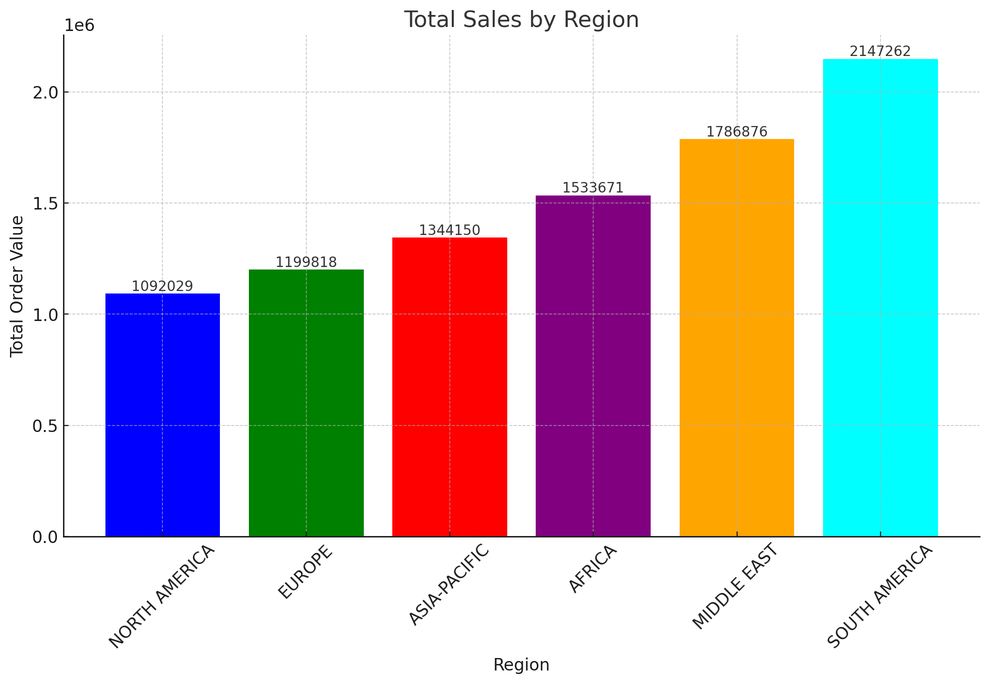

assistant:
Here is the chart displaying the total sales by region, with each region represented in a different color.

processing completed


In [16]:
process_message("Chart the sales by region. Use different colors for each region.")

processing starting
Completed Run Status: completed
assistant:
Here is the total sales data for each region displayed as a table:

| Region         | Number of Orders | Total Order Value | Avg Order Value | Avg Shipping Cost |
|----------------|------------------|-------------------|-----------------|-------------------|
| NORTH AMERICA  | 62,555           | 1,092,029         | 17.46           | 7.50              |
| EUROPE         | 61,719           | 1,199,818         | 19.44           | 7.50              |
| ASIA-PACIFIC   | 61,337           | 1,344,150         | 21.91           | 7.49              |
| AFRICA         | 61,209           | 1,533,671         | 25.06           | 7.51              |
| MIDDLE EAST    | 61,168           | 1,786,876         | 29.21           | 7.50              |
| SOUTH AMERICA  | 61,193           | 2,147,262         | 35.09           | 7.48              |



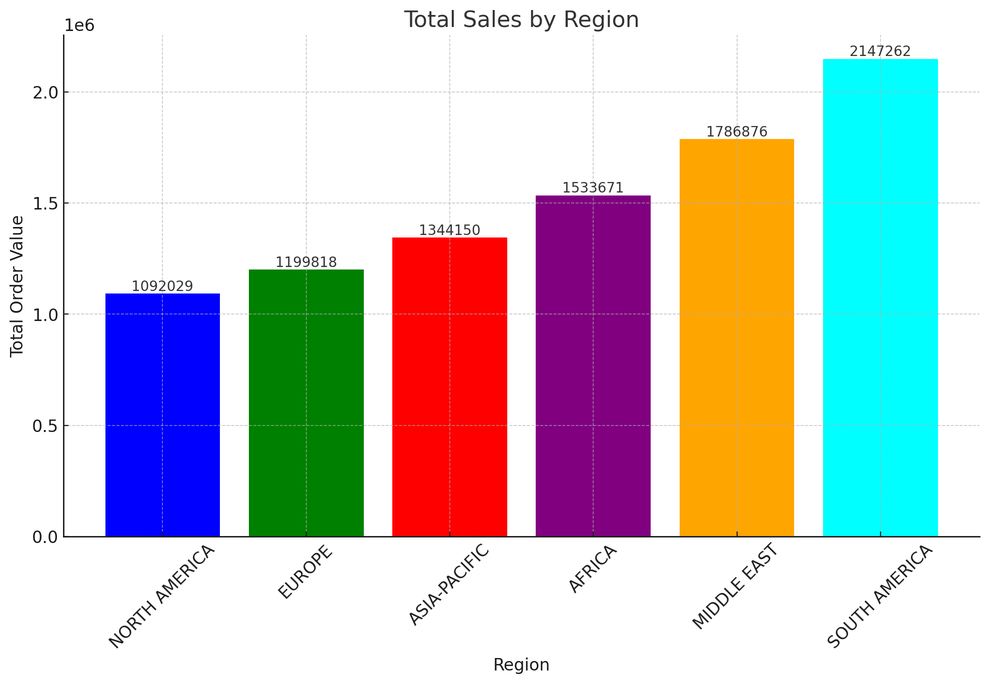

assistant:
Here is the chart displaying the total sales by region, with each region represented in a different color.

assistant:
Here is the worldwide sales revenue displayed as a table:

| Metric                  | Value    |
|-------------------------|----------|
| Worldwide Sales Revenue | 9,103,806 |

processing completed


In [17]:
process_message("Calculate the worldwide sales revenue. Display as a table.")

processing starting
Completed Run Status: requires_action
Function Calling
{'tool_calls': [{'id': 'call_dHV1j2K6FOhCzTpfRPqNZOnI', 'function': {'arguments': '{"month":3}', 'name': 'get_sales_by_month'}, 'type': 'function'}]}
Completed Run Status: completed
assistant:
Here is the total sales data for each region displayed as a table:

| Region         | Number of Orders | Total Order Value | Avg Order Value | Avg Shipping Cost |
|----------------|------------------|-------------------|-----------------|-------------------|
| NORTH AMERICA  | 62,555           | 1,092,029         | 17.46           | 7.50              |
| EUROPE         | 61,719           | 1,199,818         | 19.44           | 7.50              |
| ASIA-PACIFIC   | 61,337           | 1,344,150         | 21.91           | 7.49              |
| AFRICA         | 61,209           | 1,533,671         | 25.06           | 7.51              |
| MIDDLE EAST    | 61,168           | 1,786,876         | 29.21           | 7.50        

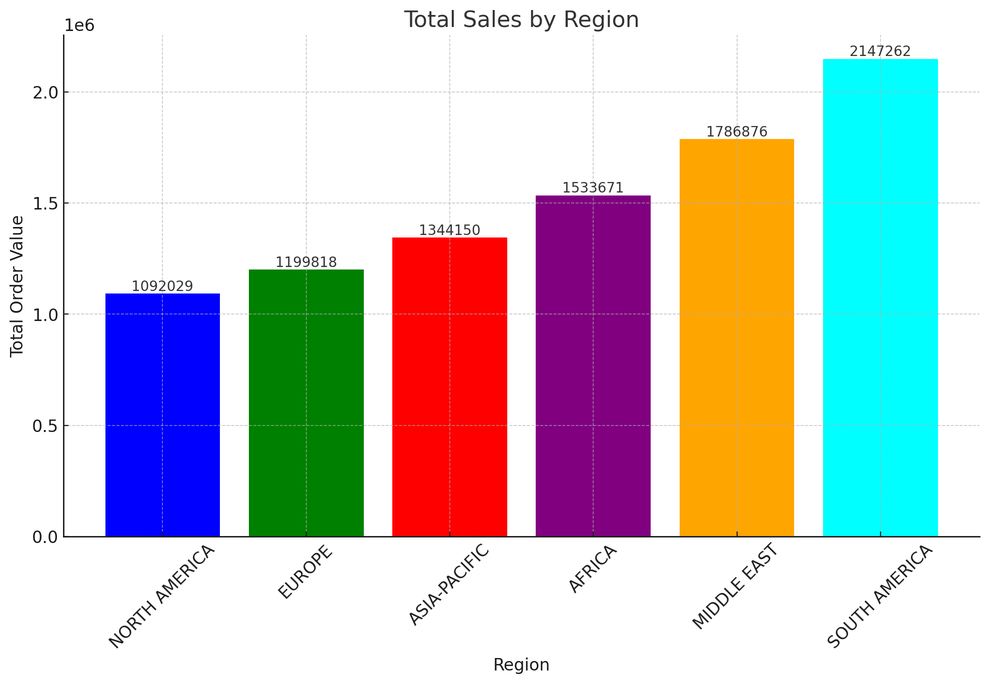

assistant:
Here is the chart displaying the total sales by region, with each region represented in a different color.

assistant:
Here is the worldwide sales revenue displayed as a table:

| Metric                  | Value    |
|-------------------------|----------|
| Worldwide Sales Revenue | 9,103,806 |

assistant:
Here are the sales for March displayed as a table:

| Revenue      | Month | Year |
|--------------|-------|------|
| 788,892.67   | 3     | 2023 |
| 493,781.75   | 3     | 2024 |

processing completed


In [18]:
process_message("what were the sales for March? Display as a table.")

## Cleaning up

In [19]:
if should_cleanup:
    client.beta.assistants.delete(assistant.id)
    client.beta.threads.delete(thread.id)
    for file in assistant_files:
        client.files.delete(file.id)